# Test using the log marginal likelihood to estimate GP parameters

See this nice blog:
    http://krasserm.github.io/2018/03/19/gaussian-processes/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xarray as xr
from scipy import signal
from scipy.sparse import linalg as sla
from scipy import linalg as la
from scipy import stats
from tqdm import tqdm
from scipy.optimize import minimize

from oceanoi import cov, oi, variogram

In [2]:
plt.rcParams['pcolor.shading'] = 'auto'

10.0

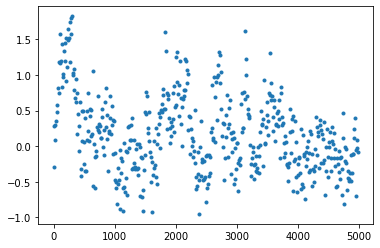

In [71]:
np.random.seed(1) # this generates the same output every time
# Generate some training data
noise = 0.3
covparams = (0.45, 75)
covfunc = cov.matern52_1d
dx = 10.

N = 500
xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*10)

K = covfunc(xd[:,None], xd[:,None].T, covparams)

# L = la.cholesky(K+1e-7*np.eye(N))
# yd = L.dot(noise*np.random.normal(size=(N,)))

mu = np.zeros_like(xd)
yd = np.random.multivariate_normal(mu.ravel(), K, 1).ravel()
yd += noise*np.random.normal(size=(N,))
yd.shape
plt.figure()
plt.plot(xd, yd,'.')
dx

In [72]:
# Compare determinant calculations
L = la.cholesky(K+1e-7*np.eye(N))
logdetK = 2*np.sum(np.log(np.diagonal(L))) 

logdetK, la.det(K+1e-7*np.eye(N)), np.linalg.det(K), np.linalg.slogdet(K)

(-3809.272812657565, 0.0, 0.0, (1.0, -3811.3648407375895))

CPU times: user 231 ms, sys: 242 ms, total: 473 ms
Wall time: 315 ms


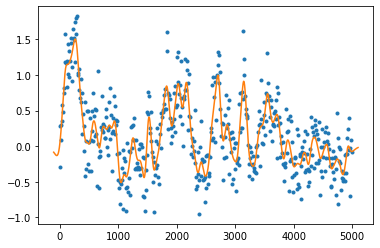

In [73]:
%%time
# Create a 3D OI object

scale = 1

OI = oi.OptimalInterp1D(xd*scale,  \
                            xo*scale,\
                            noise, covfunc, covparams)

yoi = OI(yd[:,None])

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xo, yoi,'')

In [74]:
# Minimize the log marginal likelihood
def minfunc( params, x, Z, covfunc):
    #print(params)
    noise = params[0]
    covparams = params[1:]
    
    myOI = oi.OptimalInterp1D(x, x, noise, covfunc, covparams)
    #nll = myOI.neg_log_marginal_likelihood(x, Z, noise, covfunc, covparams)
    nll = -myOI.log_marg_likelihood(Z)

    #     print(nll)
    return nll

method = 'L-BFGS-B'
bounds =( (0.01,1), (0.05,2*dx), (0.2, 200.)) 
# bounds = None
covparams_ic = (0.5, 0.5, 12)
options = None #{'eps':1e-6}

# def optlog(x):
#     print(x)

soln = minimize(minfunc, covparams_ic,
         args=(xd*scale,  yd[:,None],  covfunc),
            method=method,
            bounds=bounds,
            options=options,
         ) 
soln['x'],  noise,  covparams[0], covparams[1]

(array([ 0.29177674,  0.4594855 , 82.83618014]), 0.3, 0.45, 75)

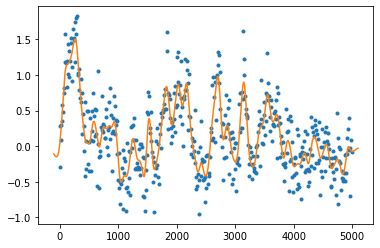

In [75]:
OI = oi.OptimalInterp1D(xd*scale,  \
                            xo*scale,\
                            soln['x'][0], covfunc, soln['x'][1:])

yoi = OI(yd[:,None])

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xo, yoi,'')

In [76]:
# Test out prior calculations

In [77]:
# Minimize the log marginal likelihood
def minfunc_prior( params, priors, x, Z, covfunc):
    #print(params)
    noise = params[0]
    covparams = params[1:]
    
    myOI = oi.OptimalInterp1D(x, x, noise, covfunc, covparams)
    #nll = myOI.neg_log_marginal_likelihood(x, Z, noise, covfunc, covparams)
    nll = -myOI.log_marg_likelihood(Z)
    
    ## Add on the priors
    log_prior = np.array([P.logpdf(val) for P, val in zip(priors, params)])
    #print(nll, log_prior, nll - np.prod(log_prior))
    if np.any(np.isinf(log_prior)):
        return 1e6
    
    return nll - np.sum(log_prior)

method = 'L-BFGS-B'
# method = 'Powell'

bounds =( (0.01, None), (0.01,None), (0.2, None)) 
# bounds = None

priors = [
    stats.uniform(0,1),
    stats.norm(1,1),
    stats.norm(100,20)
]
options = None #{'eps':1e-6}

# def optlog(x):
#     print(x)
covparams_ic = (0.5, 0.5, 10)
# Draw initial conditions from the priors
# covparams_ic = [P.rvs() for P in priors]
print(covparams_ic)
soln = minimize(minfunc_prior, covparams_ic,
         args=(priors, xd*scale,  yd[:,None],  covfunc),
            method=method,
            bounds=bounds,
            options=options,
         ) 
soln['x'],  noise,  covparams[0], covparams[1]

(0.5, 0.5, 10)


(array([ 0.29246987,  0.47078237, 86.75254713]), 0.3, 0.45, 75)

In [78]:
stats.invgamma(0.1,0.1).logpdf(0.5)

-3.7447928466726355

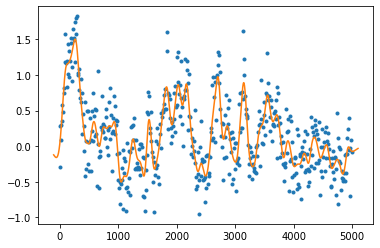

In [79]:
OI = oi.OptimalInterp1D(xd*scale,  \
                            xo*scale,\
                            soln['x'][0], covfunc, soln['x'][1:])

yoi = OI(yd[:,None])

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xo, yoi,'')